In [1]:

from classes.Settings import Settings
from lib.solve import solve
from matplotlib import pyplot as plt 
from lib.parse_json import parse_json

# Part 1: RL Circuit

In [2]:
devices = parse_json('testcases/RL_circuit.json')
results = solve(devices, Settings(simulationTime=0.2, timestep=0.0001))

Circuit has 13 nodes
Total Y matrix size for circuit will be 28


### Output Voltage Plot

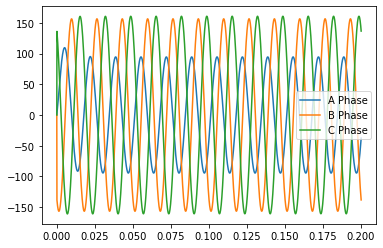

In [3]:
waveforms = [
    (results.get_node_voltage("n3_a"), "A Phase"),
    (results.get_node_voltage("n3_b"), "B Phase"),
    (results.get_node_voltage("n3_c"), "C Phase")
]

x = results.get_timesteps()

for (waveform, label) in waveforms:
    plt.plot(x, waveform, label=label)

plt.legend()
plt.show()

### Output Current Plot